# Setup

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.cuda import empty_cache
from torchvision import transforms

In [ ]:
from google.colab import drive
drive.mount('drive')
GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/dunet'
sys.path.append(GOOGLE_DRIVE_PATH)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
from dataset import *
from models import *
from loss import *
from utils.pre_processing import *

# Utility

In [ ]:
class Averagvalue(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy_check(mask, prediction):
    ims = [mask, prediction]
    np_ims = []
    for item in ims:
        if 'PIL' in str(type(item)):
            item = np.array(item)
        elif 'torch' in str(type(item)):
            item = item.cpu().detach().numpy()
        np_ims.append(item)
    compare = np.equal(np.where(np_ims[0] > 0.5, 1, 0), np_ims[1])
    accuracy = np.sum(compare)
    return accuracy / len(np_ims[0].flatten())

In [ ]:
def BCELoss(prediction, label):
    masks_probs_flat = prediction.view(-1)
    true_masks_flat = label.float().view(-1)
    loss = nn.BCELoss()(masks_probs_flat, true_masks_flat)
    return loss

In [ ]:
def load_hdf5(infile):
    with h5py.File(infile, "r") as f:  # "with" close the file after its nested commands
        return f["image"][()]

In [ ]:
def extract_random_patches(full_imgs, full_masks, patch_h, patch_w, N_patches_per_img):

    assert (len(full_imgs.shape) == 4 and len(full_masks.shape) == 4)
    assert (full_imgs.shape[0] == full_masks.shape[0] and full_imgs.shape[2] == full_masks.shape[2] and full_imgs.shape[3] == full_masks.shape[3])
    assert (full_imgs.shape[1] == 1 or full_imgs.shape[1] == 3)
    assert (full_masks.shape[1] == 1)

    N_images, N_channels = full_imgs.shape[0], full_imgs.shape[1]
    img_h, img_w = full_imgs.shape[2], full_imgs.shape[3]
    patches_imgs = np.empty((N_images * N_patches_per_img, N_channels, patch_h, patch_w))
    patches_masks = np.empty((N_images * N_patches_per_img, N_channels, patch_h, patch_w))

    i_patch = 0
    for i in range(N_images):
        k = 0
        while k < N_patches_per_img:
            x_center = np.random.randint(low=int(patch_w / 2), high=img_w - int(patch_w / 2))
            y_center = np.random.randint(low=int(patch_h / 2), high=img_h - int(patch_h / 2))
            patch_img = full_imgs[i, :, y_center - int(patch_h / 2):y_center + int(patch_h / 2), x_center - int(patch_w / 2):x_center + int(patch_w / 2)]
            patch_mask = full_masks[i, :, y_center - int(patch_h / 2):y_center + int(patch_h / 2), x_center - int(patch_w / 2):x_center + int(patch_w / 2)]
            patches_imgs[i_patch] = patch_img
            patches_masks[i_patch] = patch_mask
            i_patch += 1
            k += 1

    return patches_imgs, patches_masks

In [ ]:
def get_data_training(train_imgs_original, train_masks, patch_height, patch_width, N_patches_per_image):
    train_imgs = my_PreProc(train_imgs_original)
    train_masks = train_masks / 255.0
    assert (np.min(train_masks) == 0 and np.max(train_masks) == 1)

    patches_imgs_train, patches_masks_train = extract_random_patches(train_imgs, train_masks, patch_height, patch_width, N_patches_per_image)
    return patches_imgs_train, patches_masks_train

# Train and Test Functions

In [ ]:
def test(model, test_loader, epoch):
    model.eval()
    epoch_time = Averagvalue()
    losses = Averagvalue()
    acc = Averagvalue()
    end = time.time()

    with torch.no_grad():
        for i, (image, mask) in enumerate(test_loader):
            image = image.float().to(device).requires_grad_(False)
            mask = mask.to(device).requires_grad_(False)
            pred = model(image)

            loss = loss_fn(pred, mask)
            # loss_fn(pred, onehot(mask, 2).cuda())
            accuracy = accuracy_check(pred, mask)
            acc.update(accuracy, 1)

            losses.update(loss.item(), image.size(0))

        # measure elapsed time
    epoch_time.update(time.time() - end)
    info = 'TEST Epoch: [{0}/{1}]'.format(epoch, N_epochs) + \
           'Test Epoch Time {batch_time.val:.3f} (avg:{batch_time.avg:.3f}) '.format(batch_time=epoch_time) + \
           'Acc {acc.val:f} (avg:{acc.avg:f}) '.format(acc=acc) + \
           'Loss {loss.val:f} (avg:{loss.avg:f}) '.format(loss=losses)
    print(info)
    return losses.avg, acc.avg

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()

    losses = Averagvalue()
    acc = Averagvalue()
    optimizer.zero_grad()
    for i, (image, mask) in enumerate(train_loader):
        image = image.float().to(device)
        mask = mask.float().to(device)
        pred = model(image)

        loss = loss_fn(pred, mask)
        # loss = loss_fn(pred, onehot(mask, 2).cuda())
        accuracy = accuracy_check(pred, mask)
        acc.update(accuracy, 1)

        losses.update(loss.item(), image.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses.avg, acc.avg

# Vessels Dataset

In [ ]:
patches_imgs_train, patches_masks_train = get_data_training(
    train_imgs_original=load_hdf5(os.path.join(GOOGLE_DRIVE_PATH, "DRIVE_dataset/DRIVE_imgs_train.hdf5")),
    train_masks=load_hdf5(os.path.join(GOOGLE_DRIVE_PATH, "DRIVE_dataset/DRIVE_groundTruth_train.hdf5")),
    patch_height=48,
    patch_width=48,
    N_patches_per_image=1000
)

patches_imgs_train = np.transpose(patches_imgs_train, (0, 2, 3, 1))
patches_masks_train = np.transpose(patches_masks_train, (0, 2, 3, 1))
training_data = vessel_dataset(patches_imgs_train, patches_masks_train, 0.9, split='train')
validation_data = vessel_dataset(patches_imgs_train, patches_masks_train, 0.9, split='val')

training_loader = torch.utils.data.DataLoader(training_data, batch_size=4, shuffle=True, num_workers=1)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=False, num_workers=1)

### Train Model

In [ ]:
device = 'cuda'

mymodel = DUNetV1V2(n_channels=1, n_classes=1).to(device)
optimizer = torch.optim.Adam(mymodel.parameters(), lr=5e-5, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=12)
loss_fn = nn.BCELoss()
# loss_fn = DiceLoss(p=1)

N_epochs = 10

In [ ]:
for epoch in range(N_epochs):
    train_loss, train_acc = train(mymodel, training_loader, optimizer, epoch)
    print(f"EPOCH {epoch} | Training Loss: {train_loss}, Training Accuracy: {train_acc}")
    filename = os.path.join(GOOGLE_DRIVE_PATH, 'checkpoints', 'checkpoint_epoch_%03d.pth' % (epoch + 1))
    torch.save({
        'epoch': epoch + 1,
        'state_dict': mymodel.state_dict(),
        'optimizer': optimizer.state_dict()
    }, filename)
    # val_loss, val_acc = test(mymodel, validation_loader, epoch)
    # scheduler.step(val_loss)
    # print(f"EPOCH {epoch} | Validation Accuracy: {val_acc}")

EPOCH 0 | Training Loss: 0.6904429908129904, Training Accuracy: 0.6354325086805557
EPOCH 1 | Training Loss: 0.5534509897066487, Training Accuracy: 0.8394870997299386
EPOCH 2 | Training Loss: 0.4972691416574849, Training Accuracy: 0.8846322096836416
EPOCH 3 | Training Loss: 0.4514270029862722, Training Accuracy: 0.9165263310185199
EPOCH 4 | Training Loss: 0.43357691751586064, Training Accuracy: 0.928747853973766
EPOCH 5 | Training Loss: 0.4240513214601411, Training Accuracy: 0.934915653935184
EPOCH 6 | Training Loss: 0.41724357644054627, Training Accuracy: 0.9442962721836403
EPOCH 7 | Training Loss: 0.4114217222399182, Training Accuracy: 0.9470640914351847
EPOCH 8 | Training Loss: 0.40706935768326125, Training Accuracy: 0.951206983024689
EPOCH 9 | Training Loss: 0.4027508154279656, Training Accuracy: 0.9517147714120363


In [ ]:
# mymodel = DUNetV1V2(n_channels=1, n_classes=1)
# mymodel.load_state_dict(torch.load('/content/drive/MyDrive/dunet/checkpoints/DRIVE_BCELoss/checkpoint_epoch_010.pth')['state_dict'])

<All keys matched successfully>

In [ ]:
test_imgs_original = load_hdf5("/content/drive/MyDrive/dunet/DRIVE_dataset/DRIVE_imgs_test.hdf5")
test_imgs = my_PreProc(test_imgs_original)
test_imgs = np.transpose(test_imgs, (0, 2, 3, 1))

### Evaluate (BCELoss)

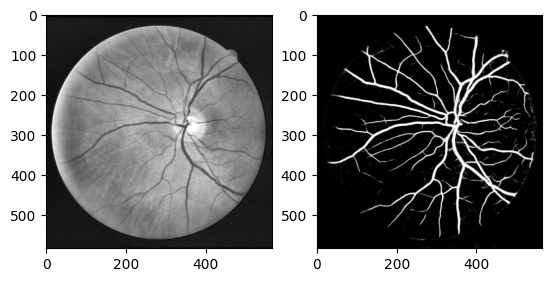

In [ ]:
sample_image = transforms.ToTensor()(test_imgs[3])
mymodel.eval()
with torch.no_grad():
  sample_pred = mymodel(sample_image.float().unsqueeze(0).to(device))
sample_pred = sample_pred.squeeze().detach().cpu().numpy()

f, ax = plt.subplots(1, 2)
ax[0].imshow(sample_image.squeeze(), cmap='gray')
ax[1].imshow(sample_pred, cmap='gray')
plt.show()

### Evaluate (Dice Loss)

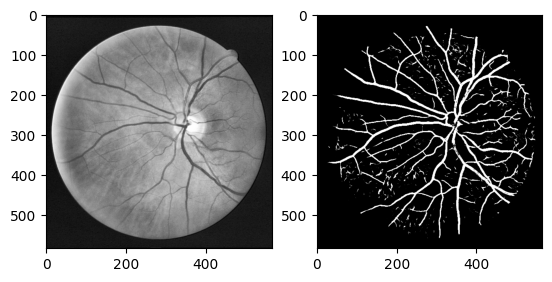

In [ ]:
sample_image = transforms.ToTensor()(test_imgs[3])
mymodel.eval()
with torch.no_grad():
  sample_pred = mymodel(sample_image.float().unsqueeze(0).to(device))
sample_pred = sample_pred.squeeze().detach().cpu().numpy()

f, ax = plt.subplots(1, 2)
ax[0].imshow(sample_image.squeeze(), cmap='gray')
ax[1].imshow(sample_pred, cmap='gray')
plt.show()

# Lesions Dataset

In [ ]:
patches_imgs_train, patches_masks_train = get_data_training(
    train_imgs_original=load_hdf5(os.path.join(GOOGLE_DRIVE_PATH, "IDRID_dataset/IDRID_imgs_train.hdf5")),
    train_masks=load_hdf5(os.path.join(GOOGLE_DRIVE_PATH, "IDRID_dataset/IDRID_groundTruth_train.hdf5")),
    patch_height=64,
    patch_width=64,
    N_patches_per_image=500
)

patches_imgs_train = np.transpose(patches_imgs_train, (0, 2, 3, 1))
patches_masks_train = np.transpose(patches_masks_train, (0, 2, 3, 1))
training_data = vessel_dataset(patches_imgs_train, patches_masks_train, 0.9, split='train')
validation_data = vessel_dataset(patches_imgs_train, patches_masks_train, 0.9, split='val')

training_loader = torch.utils.data.DataLoader(training_data, batch_size=4, shuffle=True, num_workers=1)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=False, num_workers=1)

### Visualize Patches and Masks

In [ ]:
patches, masks = [], []
for i in range(36):
  patch, mask = training_data[i]
  patches.append(patch)
  masks.append(mask)

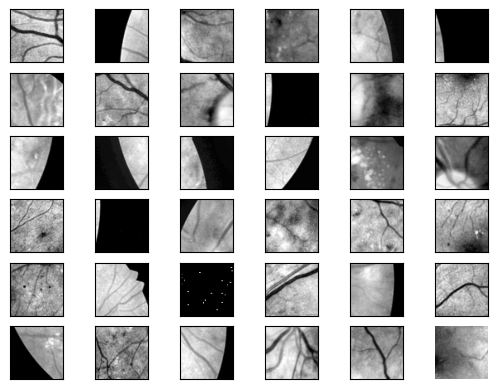

In [ ]:
f, ax = plt.subplots(6, 6)
for i in range(36):
  row = i // 6
  col = i % 6
  ax[row, col].imshow(patches[i].squeeze(), cmap='gray')
  ax[row, col].set_xticks([])
  ax[row, col].set_yticks([])
plt.show()

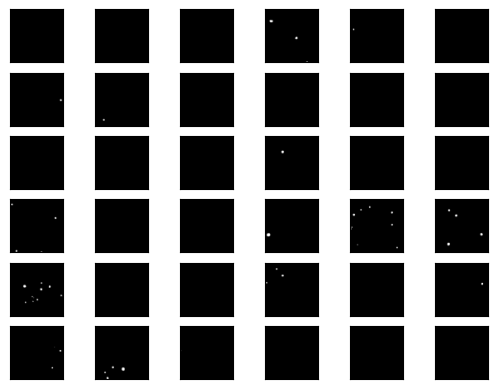

In [ ]:
f, ax = plt.subplots(6, 6)
for i in range(36):
  row = i // 6
  col = i % 6
  ax[row, col].imshow(masks[i].squeeze(), cmap='gray')
  ax[row, col].set_xticks([])
  ax[row, col].set_yticks([])
plt.show()

### Train Model

In [ ]:
device = 'cuda'

mymodel = DUNetV1V2(n_channels=1, n_classes=1).to(device)
optimizer = torch.optim.Adam(mymodel.parameters(), lr=5e-5, weight_decay=1e-5)
loss_fn = nn.BCELoss()
# loss_fn = DiceLoss(p=1)

N_epochs = 10

In [ ]:
for epoch in range(N_epochs):
    train_loss, train_acc = train(mymodel, training_loader, optimizer, epoch)
    print(f"EPOCH {epoch} | Training Loss: {train_loss}, Training Accuracy: {train_acc}")
    filename = os.path.join(GOOGLE_DRIVE_PATH, 'checkpoints', 'checkpoint_epoch_%03d.pth' % (epoch + 1))
    torch.save({
        'epoch': epoch + 1,
        'state_dict': mymodel.state_dict(),
        'optimizer': optimizer.state_dict()
    }, filename)

EPOCH 0 | Training Loss: 0.9807731359583851, Training Accuracy: 0.7578317800765175
EPOCH 1 | Training Loss: 0.9334595043276563, Training Accuracy: 0.7845886783050412
EPOCH 2 | Training Loss: 0.8873814846164405, Training Accuracy: 0.863477265785751
EPOCH 3 | Training Loss: 0.875483586797989, Training Accuracy: 0.9522561105484825
EPOCH 4 | Training Loss: 0.8696117666670324, Training Accuracy: 0.9745132458847736
EPOCH 5 | Training Loss: 0.8660391729751241, Training Accuracy: 0.9859647975340792
EPOCH 6 | Training Loss: 0.8623092562279093, Training Accuracy: 0.9890268132716049
EPOCH 7 | Training Loss: 0.8433123958993841, Training Accuracy: 0.9951072510770319
EPOCH 8 | Training Loss: 0.8358804751031192, Training Accuracy: 0.9951462131076388
EPOCH 9 | Training Loss: 0.8316147193692839, Training Accuracy: 0.9951962368184156


In [ ]:
# mymodel = DUNetV1V2(n_channels=1, n_classes=1)
# mymodel.load_state_dict(torch.load('/content/drive/MyDrive/dunet/checkpoints/IDRID_BCELoss/checkpoint_epoch_010.pth')['state_dict'])

<All keys matched successfully>

In [ ]:
test_imgs_original = load_hdf5("/content/drive/MyDrive/dunet/IDRID_dataset/IDRID_imgs_test.hdf5")
test_imgs = my_PreProc(test_imgs_original)
test_imgs = np.transpose(test_imgs, (0, 2, 3, 1))

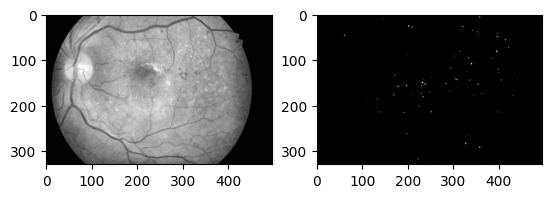

In [ ]:
sample_image = transforms.ToTensor()(test_imgs[10])
mymodel.eval()
with torch.no_grad():
  sample_pred = mymodel(sample_image.float().unsqueeze(0))
sample_pred = sample_pred.squeeze().detach().cpu().numpy()

f, ax = plt.subplots(1, 2)
ax[0].imshow(sample_image.squeeze(), cmap='gray')
ax[1].imshow(sample_pred, cmap='gray')
plt.show()